In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

Dataloaders created with the help of: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [2]:
transforms = A.Compose(
    [
        A.Resize(height=64, width=64),
        A.Normalize(mean=0.5, std=0.5),
        ToTensorV2(),
    ]
)

In [3]:
train_data_path = 'generated_at/train' 
test_data_path = 'generated_at/test'

train_image_paths = []

for data_path in glob.glob(train_data_path + '/*'):
    train_image_paths.append(data_path)
    data_path = data_path.replace(train_data_path, '')
    
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]
    
test_image_paths = []

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)
    data_path = data_path.replace(test_data_path, '')

In [4]:
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 1920
Valid size: 480
Test size: 600


In [5]:
class SymbolDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=2)
        
        label = 1 if image_filepath.split('_')[-1].split('.')[0] == 'at' else 0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

train_dataset = SymbolDataset(train_image_paths,transforms)
valid_dataset = SymbolDataset(valid_image_paths,transforms)
test_dataset = SymbolDataset(test_image_paths,transforms)

In [6]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False
)

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=2, stride=1)
        self.bn1 = nn.BatchNorm2d(50)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(50)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(50)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11250, 100)
        self.bn4 = nn.BatchNorm1d(100)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = Model()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [9]:
# Code for validation and testing
def test(model, data_loader, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.eval()
    
    for data in data_loader:
        inputs, labels = data
        
        outputs = model(inputs)
        
        preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
        correct += np.sum(preds_bool)
        total += preds_bool.size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
    test_loss = running_loss / len(data_loader)
    test_acc = correct / total

    return test_loss, test_acc

In [10]:
# Code for training the model
train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(1, 11):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = model(inputs)
        
        preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
        correct += np.sum(preds_bool)
        total += preds_bool.size

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    train_acc = correct / total
    train_accs.append(train_acc)
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    val_loss, val_acc = test(model, valid_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} train - loss:', train_loss, 'acc:', train_acc)
        print(f'Epoch {epoch} val - loss:', val_loss, 'acc:', val_acc)
        
        
print('Finished Training')

Epoch 5 train - loss: 0.001513449611472121 acc: 1.0
Epoch 5 val - loss: 0.001687368554606413 acc: 1.0
Epoch 10 train - loss: 0.000630504522875223 acc: 1.0
Epoch 10 val - loss: 0.0008048444292702091 acc: 1.0
Finished Training


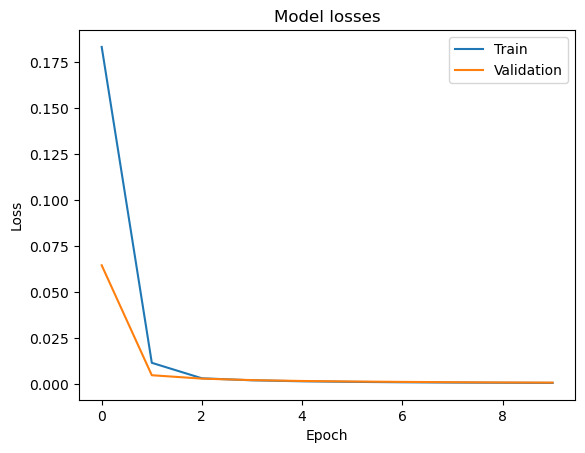

In [11]:
# Model train/val losses
plt.title('Model losses')

plt.plot(train_losses)
plt.plot(val_losses)

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

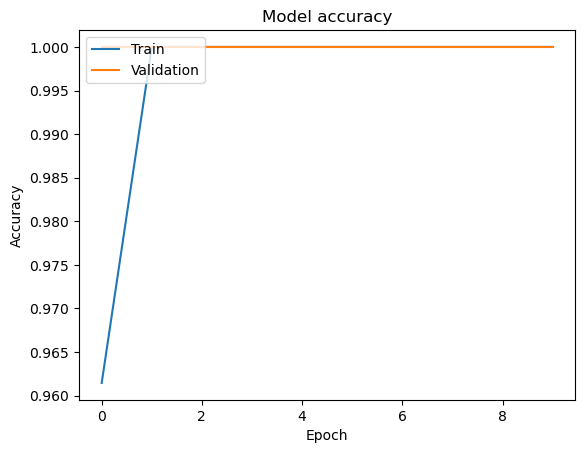

In [12]:
# Model train/val accuracy
plt.title('Model accuracy')

plt.plot(train_accs)
plt.plot(val_accs)

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
test_loss, test_acc = test(model, test_loader, criterion)

In [14]:
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.000685558649772582
Test acc: 1.0


In [15]:
scripted_model = torch.jit.script(model)
scripted_model.save('models/model_at.pt')